# Solutions 

### libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt  
import matplotlib.cm as cm 
import seaborn as sns 
%matplotlib inline 

plt.style.use("fivethirtyeight")
from warnings import filterwarnings
filterwarnings("ignore")

#import clusterig libraries
from sklearn.cluster import KMeans, SpectralClustering, DBSCAN, AgglomerativeClustering
import kmedoids
from sklearn.preprocessing import StandardScaler, LabelEncoder, normalize
from sklearn.metrics.pairwise import euclidean_distances, manhattan_distances
from sklearn.metrics import silhouette_samples, silhouette_score, fowlkes_mallows_score, calinski_harabasz_score, davies_bouldin_score


#### Import data set 

In [2]:
df = pd.read_csv("data Mall.csv", sep = ";")
print(df.shape)
df.head()

(200, 5)


,CustomerID,Genre,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Genre                   200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


In [4]:
x = df.iloc[:, 2:5].values
y = LabelEncoder().fit_transform(df.iloc[:, 1])
x.shape

(200, 3)

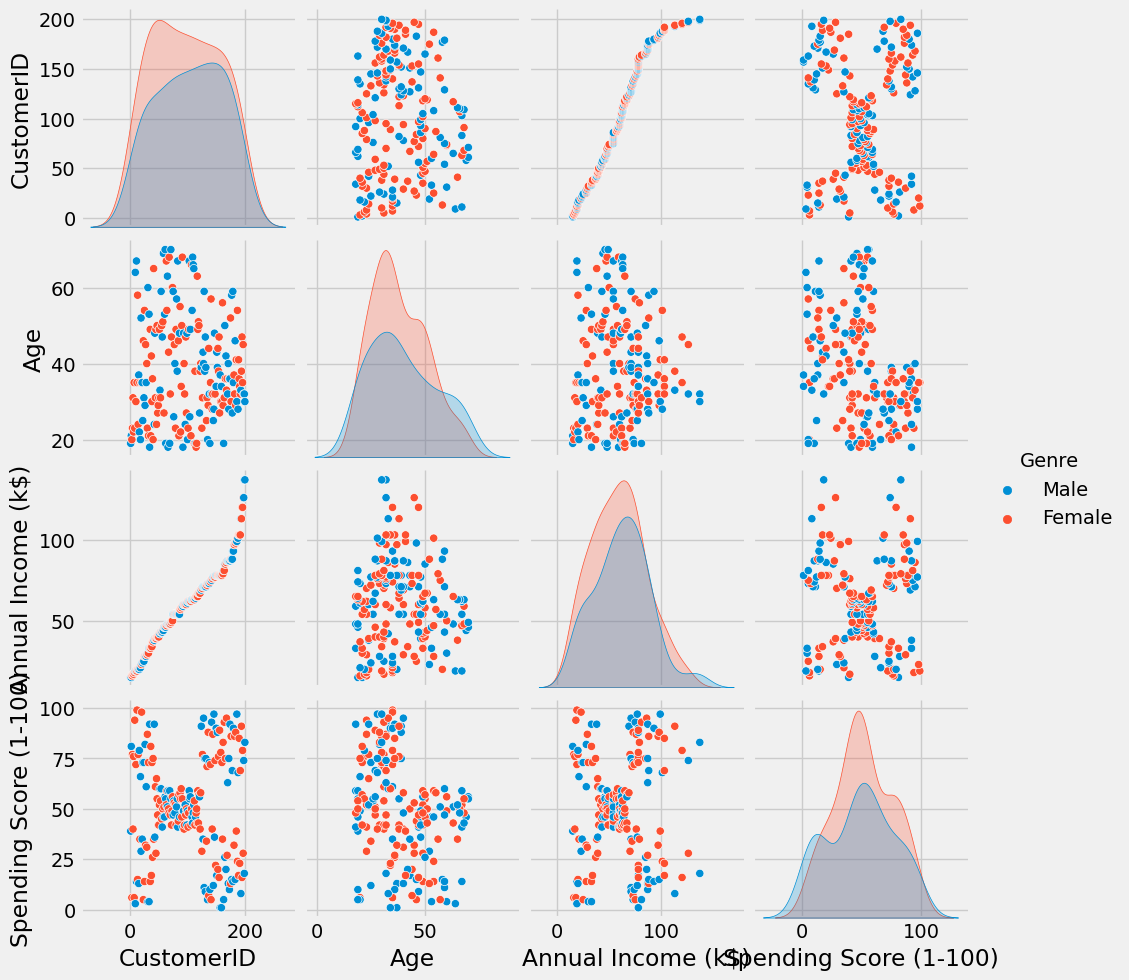

In [5]:
sns.pairplot(df, hue="Genre");

1. Make scatter plots of the different variables by differentiating each point in space by the color of the sex of the individual

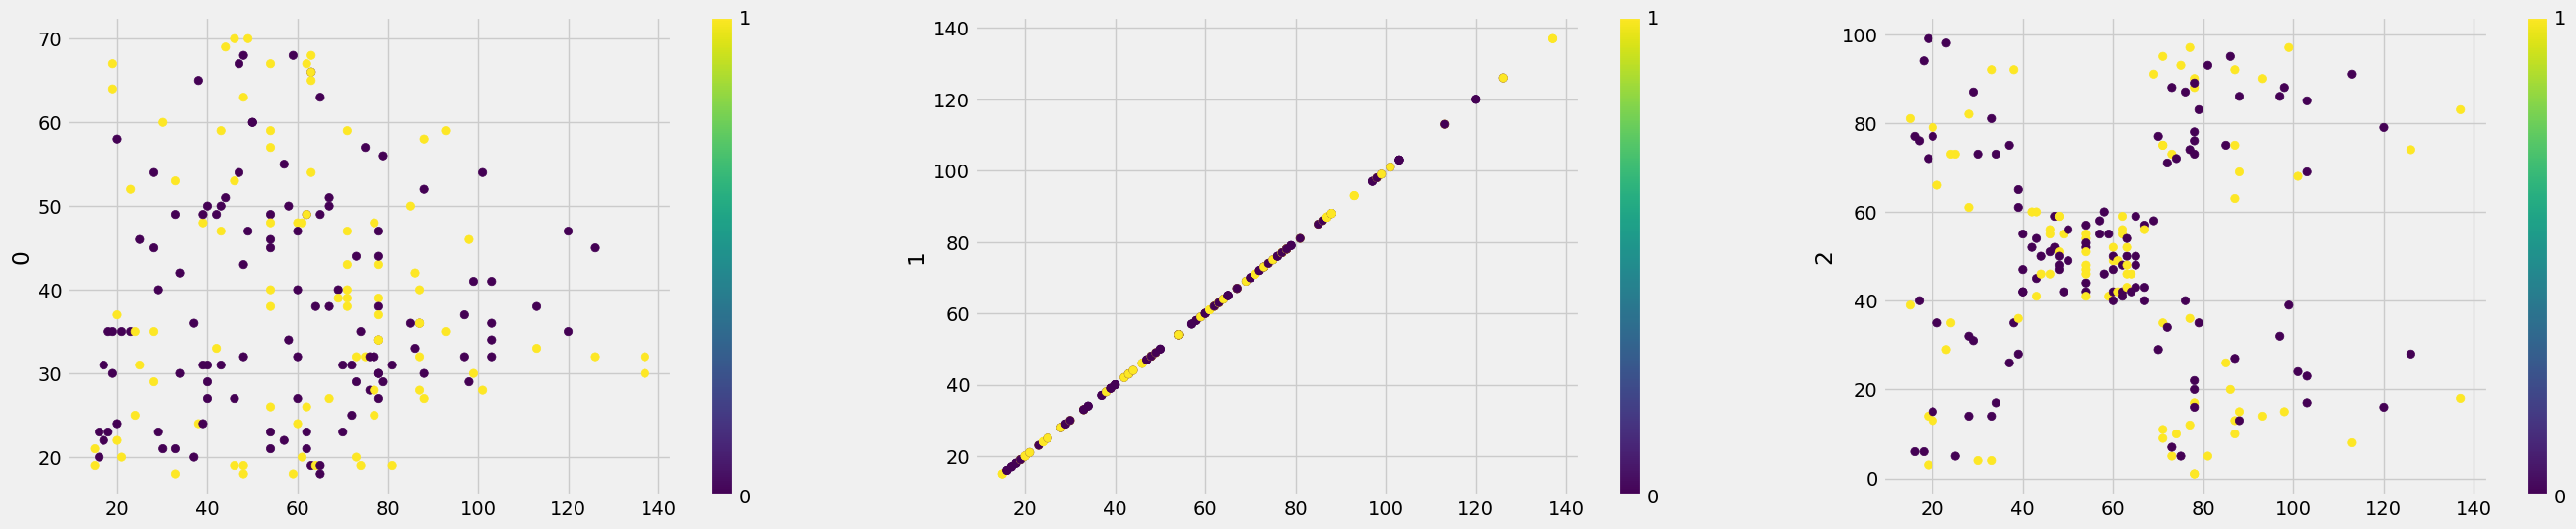

In [6]:
n = x.shape[1]
plt.figure(figsize=(30, 6))
for i in range(n):
    plt.subplot(1, 3, i+1)
    plt.scatter(x[:, 1], x[:, i], c = y)
    plt.ylabel(i)
    plt.colorbar(ticks = list(np.unique(y)));

2. Use the Elbow method in the k-means to find the optimal number of clusters.

## $k$-means

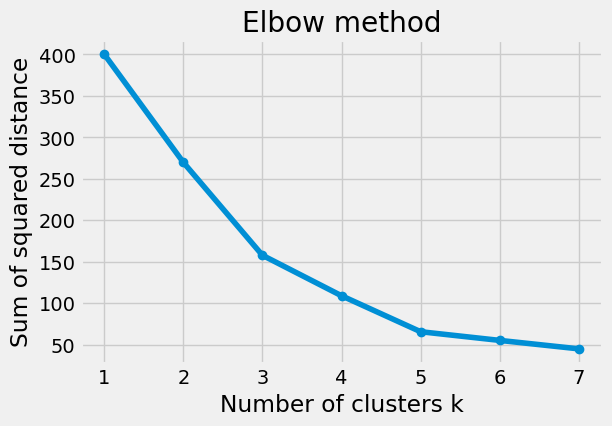

In [7]:
# Using the elbow method to find the optimal number of clusters

x_std = StandardScaler().fit_transform(df.iloc[:, 3:5].values)
sse = []
list_k = list(range(1, 8))

for k in list_k:
    km_clust = KMeans(n_clusters=k)
    km_clust.fit_predict(x_std)
    sse.append(km_clust.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 4))
plt.plot(list_k, sse, '-o')
plt.xlabel(r'Number of clusters k')
plt.ylabel('Sum of squared distance')
plt.title("Elbow method");

In [8]:
km_clust = KMeans(n_clusters=5, max_iter=100, random_state=0)
label = km_clust.fit_predict(x_std)
centroids = km_clust.cluster_centers_
centroids

array([[ 1.05500302, -1.28443907],
       [-0.20091257, -0.02645617],
       [ 0.99158305,  1.23950275],
       [-1.32954532,  1.13217788],
       [-1.30751869, -1.13696536]])

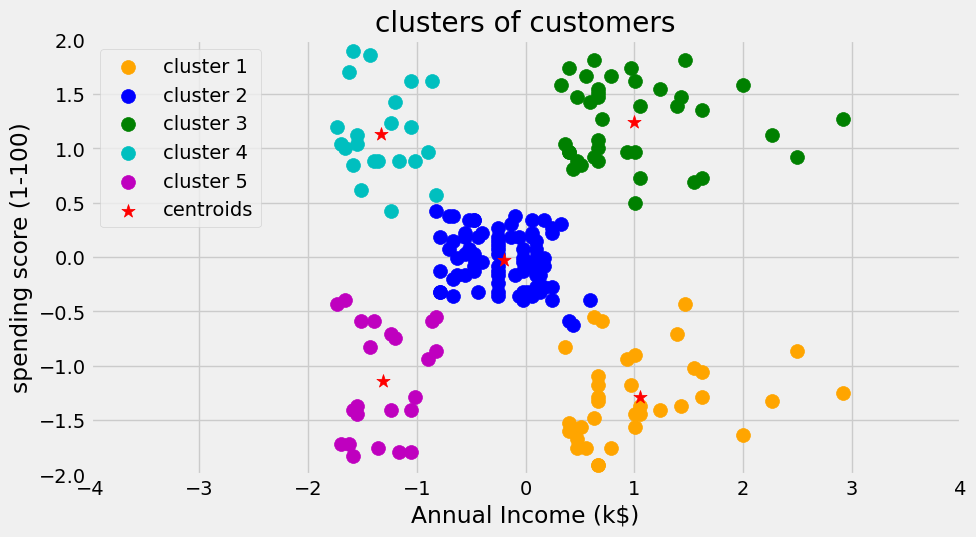

In [9]:
fig, ax = plt.subplots(figsize = (10, 6))
color = ["orange", "b", "g", "c", "m"]
lab = ["cluster 1", "cluster 2", "cluster 3", "cluster 4", "cluster 5"]
for i in range(5):
    plt.scatter(x_std[km_clust.labels_ == i, 0], x_std[km_clust.labels_ == i, 1], s = 100, c = color[i], label = lab[i])
    
plt.scatter(centroids[:, 0], centroids[:, 1], s = 100, marker="*", c = "red", label = "centroids")

plt.legend()
plt.xlim([-4, 4])
plt.ylim([-2, 2])
plt.title("clusters of customers")
plt.xlabel("Annual Income (k$)")
plt.ylabel("spending score (1-100)")
ax.set_aspect("equal");

### Evaluation 

In [10]:
sc_km = silhouette_score(x_std, km_clust.labels_)
chc_km = calinski_harabasz_score(x_std, km_clust.labels_) 
dbc_km = davies_bouldin_score(x_std, km_clust.labels_)

pd.DataFrame(data={"silhoutte score" : [sc_km], 
                   "calinski harabasz score ": [chc_km], 
                   "davies bouldin score" : [dbc_km]})

,silhoutte score,calinski harabasz score,davies bouldin score
0,0.554657,248.64932,0.572236


For n_clusters = 5 The average silhouette_score is : 0.5546571631111091


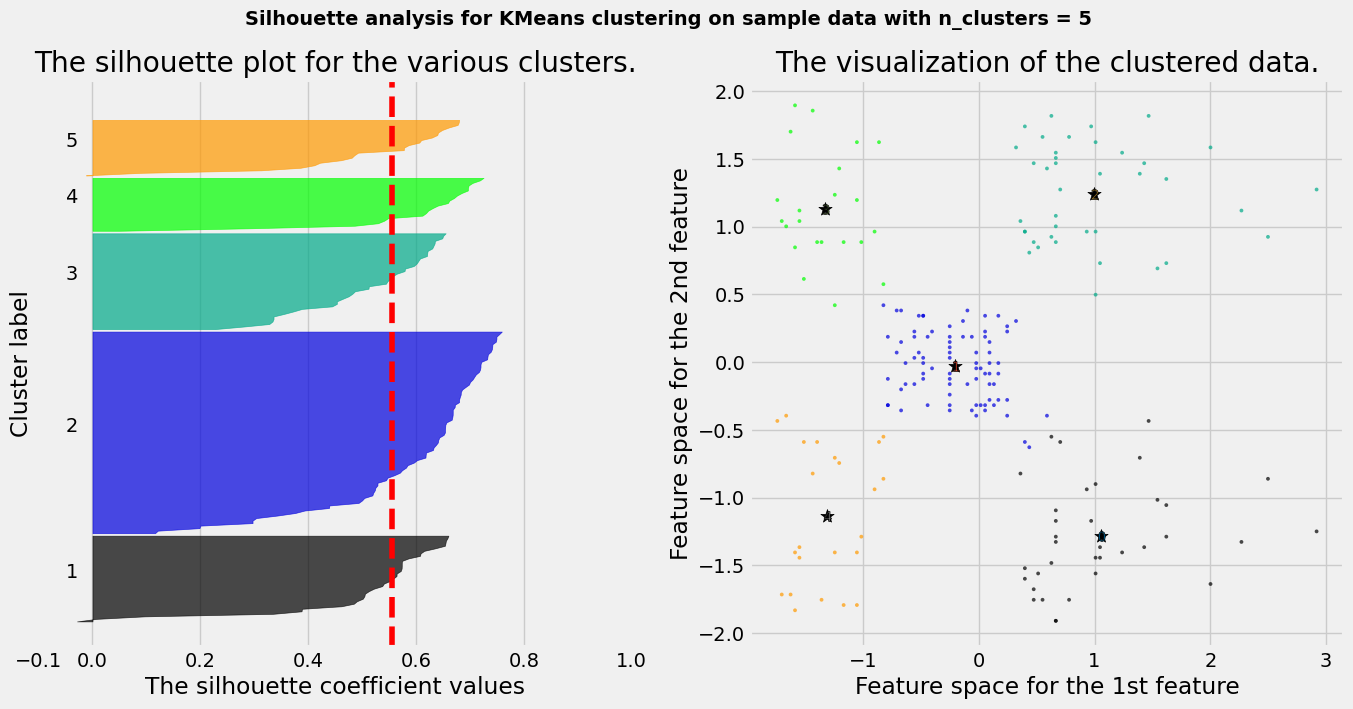

In [11]:
n_clusters = [1, 2, 3, 4, 5]
# Create a subplot with 1 row and 2 columns
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(15, 7)
# The 1st subplot is the silhouette plot
# The silhouette coefficient can range from -1, 1
ax1.set_xlim([-0.1, 1])
# The (n_clusters+1)*10 is for inserting blank space between silhouette
# plots of individual clusters, to demarcate them clearly.
ax1.set_ylim([0, len(x_std)+25])

# The silhouette_score gives the average value for all the samples.
# This gives a perspective into the density and separation of the formed clusters
silhouette_avg = silhouette_score(x_std, label)
print(
    "For n_clusters =",
    len(n_clusters),
    "The average silhouette_score is :",
    silhouette_avg)

# Compute the silhouette scores for each sample
sample_silhouette_values = silhouette_samples(x_std, label)
y_lower = 10
for i in range(len(n_clusters)):
# Aggregate the silhouette scores for samples belonging to
# cluster i, and sort them
    ith_cluster_silhouette_values = sample_silhouette_values[label == i]
    ith_cluster_silhouette_values.sort()
    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i
    color = cm.nipy_spectral(float(i) / len(n_clusters))
    ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, 
                      facecolor=color, edgecolor=color, alpha=0.7)
    
    # Label the silhouette plots with their cluster numbers at the middle
    ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i+1))
    # Compute the new y_lower for next plot
    y_lower = y_upper   # 10 for the 0 samples
    
ax1.set_title("The silhouette plot for the various clusters.")
ax1.set_xlabel("The silhouette coefficient values")
ax1.set_ylabel("Cluster label")

# The vertical line for average silhouette score of all the values
ax1.axvline(x=silhouette_avg, color="red", linestyle="--")
ax1.set_yticks([])  # Clear the yaxis labels / ticks
ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

# 2nd Plot showing the actual clusters formed
colors = cm.nipy_spectral(label.astype(float) / len(n_clusters))
ax2.scatter(x_std[:, 0], x_std[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k")

# Draw the cluster centers
ax2.scatter(centroids[:, 0], centroids[:, 1], marker="*", c="black", alpha=1, s=100, edgecolor="k")

for i, c in enumerate(centroids):
    ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")
    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle("Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"%5, 
                 fontsize=14, fontweight="bold");

## $k$-medoids

In [12]:
diss_kme = euclidean_distances(x_std)
kme_clust = kmedoids.pam(diss = diss_kme, medoids=5, max_iter=5, random_state=0)
label = kme_clust.labels

### Evaluation

indice de silhoutte intra médoide : permet d'évaluer chaque cluster de manière interne

indice de silhoutte inter cluster

In [13]:
intra_coef = kmedoids.silhouette(diss_kme, labels=kme_clust.medoids, samples = True)[0]
inter_coef = kmedoids.medoid_silhouette(diss_kme, meds=kme_clust.medoids)[0]
pd.DataFrame({"silhoutte score intra-medoid": [intra_coef], "silhoutte score inter-medoids": [inter_coef]})

,silhoutte score intra-medoid,silhoutte score inter-medoids
0,0.0,0.672271


In [14]:
sc_kme = silhouette_score(diss_kme, label)
chc_kme = calinski_harabasz_score(diss_kme, label) 
dbc_kme = davies_bouldin_score(diss_kme, label)

pd.DataFrame(data={"silhoutte score" : [sc_kme], 
                   "calinski harabasz score ": [chc_kme], 
                   "davies bouldin score" : [dbc_kme]})

,silhoutte score,calinski harabasz score,davies bouldin score
0,0.558566,179.98849,0.656422


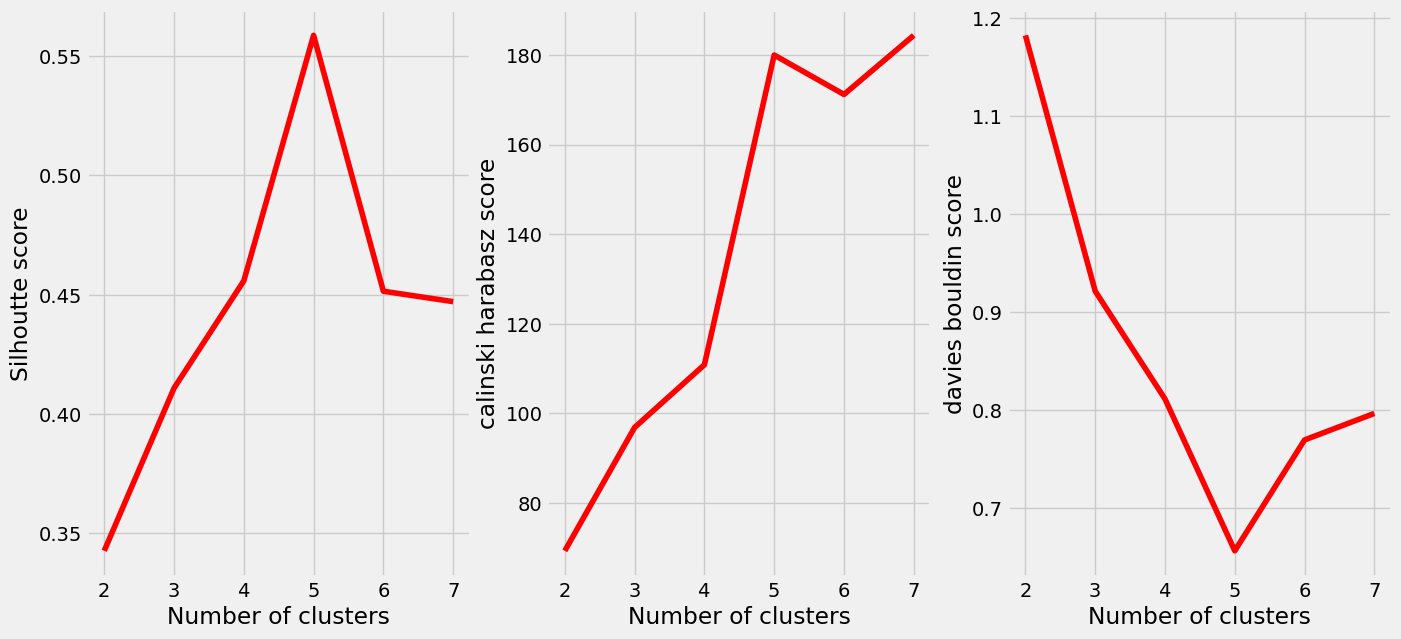

In [15]:
score_silhou, score_cal, score_dav = [], [], []
for i in range(2, 8):
    kme_clust = kmedoids.pam(diss = diss_kme, medoids=i, max_iter=5, random_state=0)
    label = kme_clust.labels
    sc_kme = silhouette_score(diss_kme, label)
    score_silhou.append(sc_kme)
    chc_kme = calinski_harabasz_score(diss_kme, label)
    score_cal.append(chc_kme)
    dbc_kme = davies_bouldin_score(diss_kme, label)
    score_dav.append(dbc_kme)

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 7)

ax[0].plot(range(2, 8), score_silhou, color = "red")
ax[1].plot(range(2, 8), score_cal, color = "red")
ax[2].plot(range(2, 8), score_dav, color = "red")
ax[0].set_xlabel("Number of clusters")
ax[0].set_ylabel("Silhoutte score")
ax[1].set_xlabel("Number of clusters")
ax[1].set_ylabel("calinski harabasz score")
ax[2].set_xlabel("Number of clusters")
ax[2].set_ylabel("davies bouldin score");

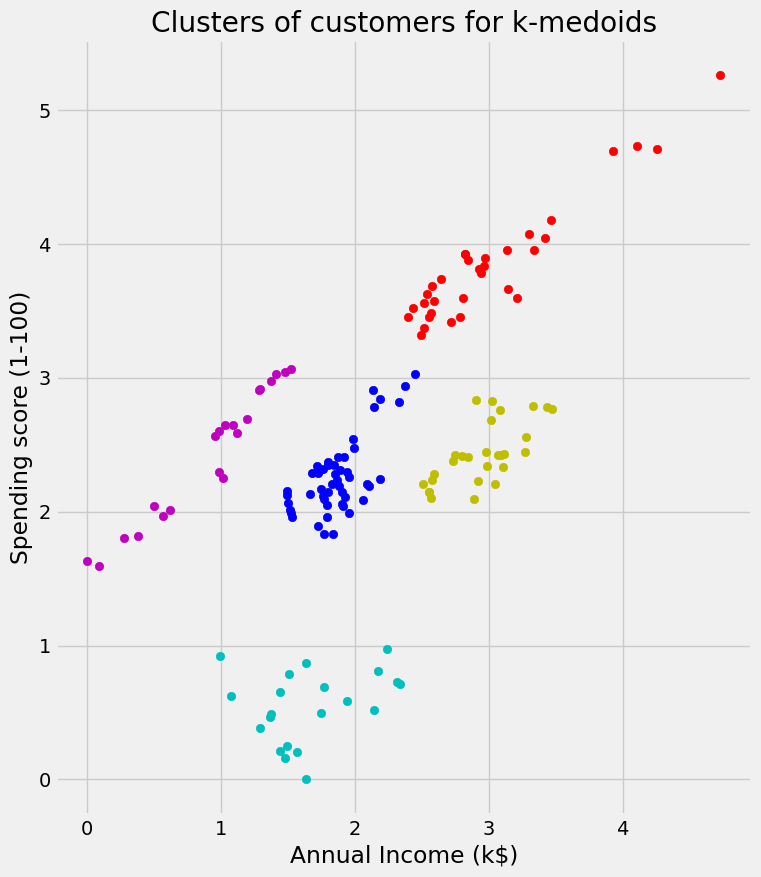

In [16]:
n_clusters = 5
colors = ['b', 'y', 'r', 'c', 'm']
fig, ax = plt.subplots(figsize = (8, 10))
for i in range(n_clusters):
    plt.scatter(diss_kme[kme_clust.labels == i, 0], 
                diss_kme[kme_clust.labels == i, 1], c=colors[i], label = "Cluster{i}")

plt.title('Clusters of customers for k-medoids')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending score (1-100)')
ax.set_aspect('equal');

## Fuzzy $C$-mean

In [17]:
# !pip install fuzzy-c-means

In [18]:
from fcmeans import FCM
# Define the number of clusters
n_clusters = 5
# Initialize the FCM algorithm
fcm = FCM(n_clusters=n_clusters, max_iter=100, random_state=0)
# Fit the data to the FCM algorithm
fcm.fit(x_std)
# Get the cluster centers and the membership matrix
centroids = fcm.centers
membership_mat = fcm.u

In [19]:
# Assign each data point to the cluster with the highest membership
fcm_labels = np.argmax(membership_mat, axis=1)
fcm_labels

array([2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3,
       2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 3, 2, 4,
       2, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
       4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 0, 1, 4, 1, 0, 1, 0, 1,
       4, 1, 0, 1, 0, 1, 0, 1, 0, 1, 4, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1], dtype=int64)

In [20]:
n_clusters_list = [2, 3, 4, 5]
models = list()
for n_clusters in n_clusters_list:
    fcm = FCM(n_clusters=n_clusters)
    fcm.fit(x_std)
    models.append(fcm)

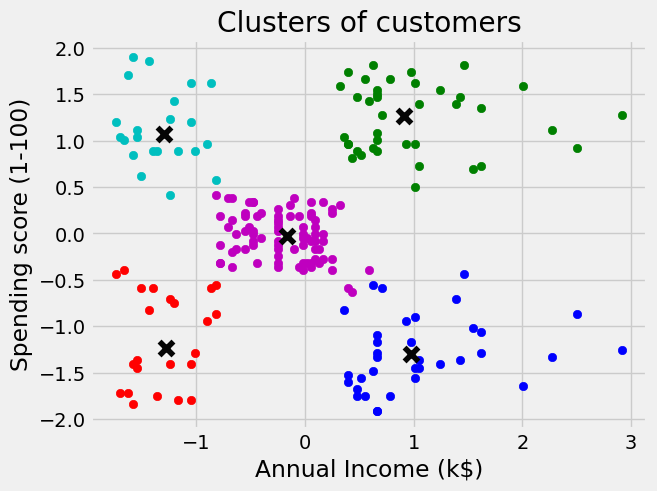

In [21]:
# Define the colors for each cluster
colors = ['b', 'g', 'r', 'c', 'm']

n_clusters=5

# Plot the data points
for i in range(n_clusters):
    plt.scatter(x_std[fcm_labels == i, 0], x_std[fcm_labels == i, 1], c=colors[i])

# Plot the centroids
plt.scatter(centroids[:, 0], centroids[:, 1], marker='x', s=100, c='#050505')

# Set the axis labels
plt.title('Clusters of customers')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending score (1-100)');

### Evaluation 

In [22]:
sc_fuz = silhouette_score(x_std, fcm_labels)
chc_fuz = calinski_harabasz_score(x_std, fcm_labels) 
dbc_fuz = davies_bouldin_score(x_std, fcm_labels)

pd.DataFrame(data={"silhoutte score" : [sc_fuz], 
                   "calinski harabasz score ": [chc_fuz], 
                   "davies bouldin score" : [dbc_fuz]})

,silhoutte score,calinski harabasz score,davies bouldin score
0,0.554657,248.64932,0.572236


## Clustering spectral

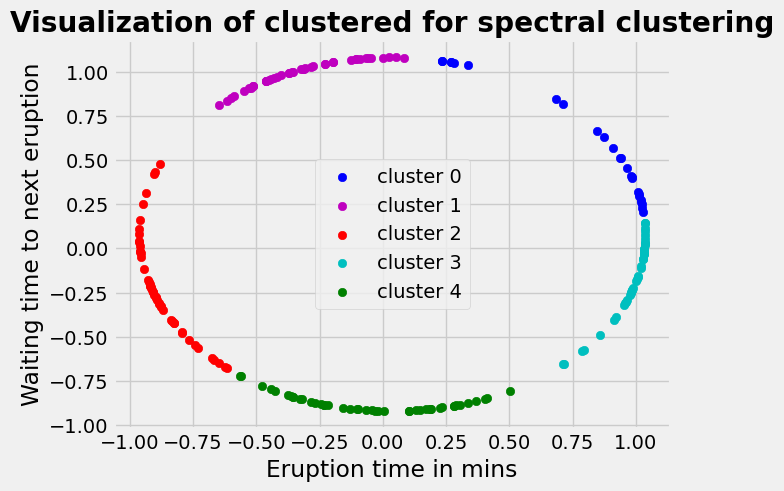

In [23]:
from sklearn.decomposition import PCA

# Normalizing the Data 
X_normalized = normalize(x_std)

# Converting the numpy array into a pandas DataFrame 
X_normalized = pd.DataFrame(X_normalized) 

# Reducing the dimensions of the data 
pca = PCA(n_components = 2) 
X_principal = pca.fit_transform(X_normalized) 
X_principal = pd.DataFrame(X_principal) 
X_principal.columns = ['P1', 'P2']   

spect_clust = SpectralClustering(n_clusters=5, affinity ="rbf",
                                 n_neighbors=10, assign_labels='kmeans', degree=5, random_state=0)
spect_clust.fit_predict(X_principal)
spect_label = spect_clust.labels_ 

# Visualizing the clustering 
# Define the colors for each cluster
colors = ['b', 'm', 'r', 'c', 'g']

n_clusters=5

# Plot the data points
for i in range(n_clusters):
    plt.scatter(X_principal.values[spect_label == i, 0], X_principal.values[spect_label == i, 1], 
                c=colors[i], label = f"cluster {i}")
plt.legend()
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending score (1-100)')
plt.title('Visualization of clustered for spectral clustering', fontweight='bold')
ax.set_aspect('equal');

In [24]:
spec_sc = silhouette_score(X_principal, spect_label)
spec_chc = calinski_harabasz_score(X_principal, spect_label) 
spce_dbc = davies_bouldin_score(X_principal, spect_label)

pd.DataFrame(data={"silhoutte score" : [spec_sc], 
                   "calinski harabasz score ": [spec_chc], 
                   "davies bouldin score" : [spce_dbc]})

,silhoutte score,calinski harabasz score,davies bouldin score
0,0.596488,516.456385,0.578514


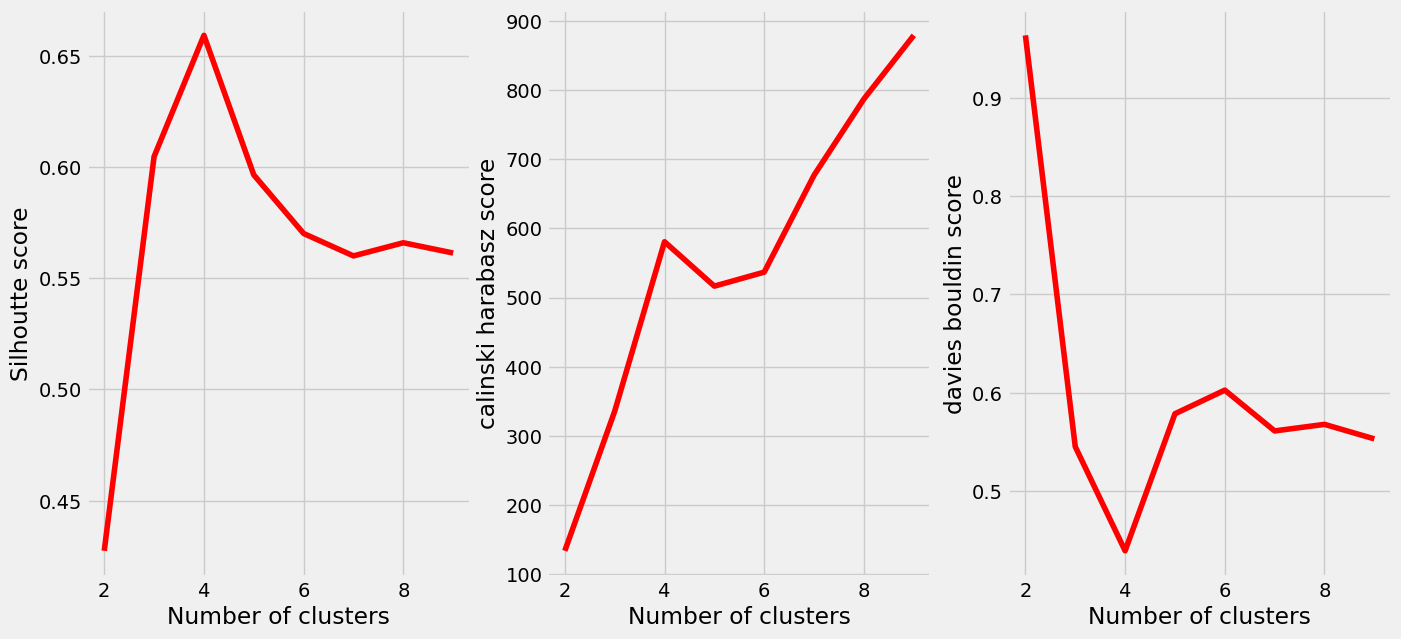

In [25]:
score_silhou, score_cal, score_dav = [], [], []
for i in range(2, 10):
    spect_clust = SpectralClustering(n_clusters=i, affinity ="rbf", assign_labels='kmeans', degree=5, random_state=0)
    spect_clust.fit_predict(X_principal)
    spect_label = spect_clust.labels_ 
    sc_kme = silhouette_score(X_principal.values, spect_label)
    score_silhou.append(sc_kme)
    chc_kme = calinski_harabasz_score(X_principal.values, spect_label)
    score_cal.append(chc_kme)
    dbc_kme = davies_bouldin_score(X_principal.values, spect_label)
    score_dav.append(dbc_kme)

fig, ax = plt.subplots(1, 3)
fig.set_size_inches(15, 7)

ax[0].plot(range(2, 10), score_silhou, color = "red")
ax[1].plot(range(2, 10), score_cal, color = "red")
ax[2].plot(range(2, 10), score_dav, color = "red")
ax[0].set_xlabel("Number of clusters")
ax[0].set_ylabel("Silhoutte score")
ax[1].set_xlabel("Number of clusters")
ax[1].set_ylabel("calinski harabasz score")
ax[2].set_xlabel("Number of clusters")
ax[2].set_ylabel("davies bouldin score");

2. Hierarchical Clustering

     - Agglomerative clustering
     - Divisive clustering

## Agglomerative clustering

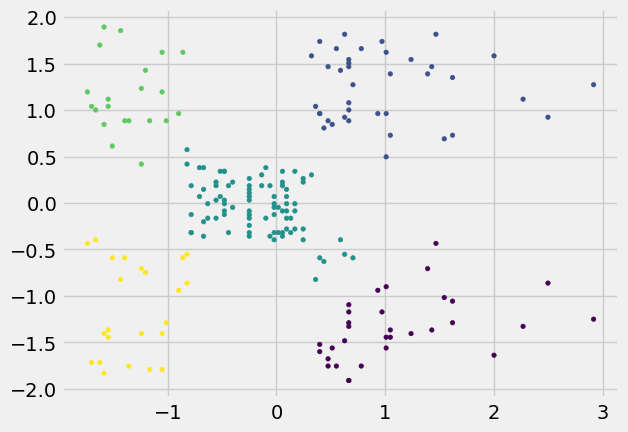

In [26]:
agg_clust = AgglomerativeClustering(n_clusters=5)
assigned_clust = agg_clust.fit_predict(x_std)
plt.scatter(x_std[:, 0], x_std[:, 1], c=assigned_clust, s=10);

In [27]:
agg_clust.labels_

array([4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3,
       4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 3, 4, 2,
       4, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 1, 2, 1, 0, 1, 0, 1,
       2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 2, 1, 0, 1, 2, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 2, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1,
       0, 1], dtype=int64)

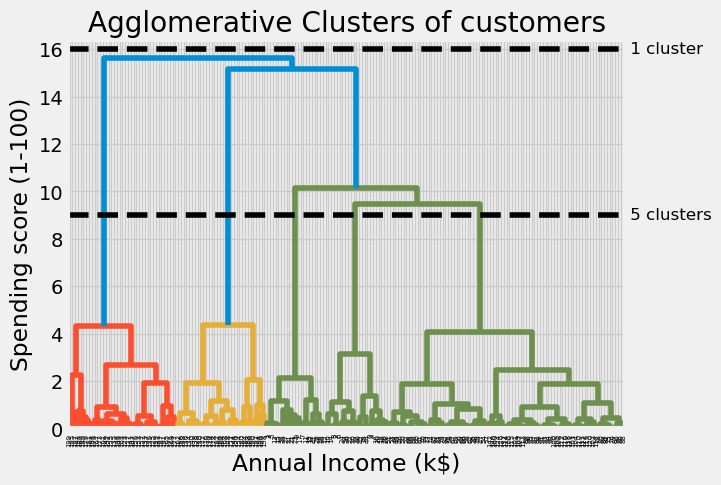

In [28]:
from scipy.cluster.hierarchy import dendrogram, ward

# Use the ward() function
linkage_array = ward(x_std)

# Now we plot the dendrogram for the linkage_array containing the distances between clusters
dendrogram(linkage_array)

ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [16, 16], '--', c='k')
ax.plot(bounds, [9, 9], '--', c='k')
ax.text(bounds[1], 16, ' 1 cluster', va='center', fontdict={'size': 12})
ax.text(bounds[1], 9, ' 5 clusters', va='center', fontdict={'size': 12})
#dendrogram(linkage_array,  truncate_mode='lastp', p=12)
plt.title('Agglomerative Clusters of customers')
plt.xlabel('Annual Income (k$)')
plt.ylabel('Spending score (1-100)');

#### Evaluation

In [29]:
sc_ag = silhouette_score(x_std, agg_clust.labels_)
chc_ag = calinski_harabasz_score(x_std,agg_clust.labels_) 
dbc_ag = davies_bouldin_score(x_std,agg_clust.labels_)


pd.DataFrame(data={"silhoutte score" : [sc_ag], 
                   "calinski harabasz score ": [chc_ag], 
                   "davies bouldin score" : [dbc_ag]})

,silhoutte score,calinski harabasz score,davies bouldin score
0,0.553809,244.410326,0.577862


### DBSCAN

In [30]:
dbsc = DBSCAN(eps = 0.4, min_samples=8)
dbsc.fit(x_std)
dbsc_label = dbsc.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters = len(set(dbsc_label)) - (1 if -1 in dbsc_label else 0)
n_noise = list(dbsc_label).count(-1)

print("Estimated number of clusters: %d" % n_clusters)
print("Estimated number of noise points: %d" % n_noise)

Estimated number of clusters: 5
Estimated number of noise points: 25


Estimated number of clusters: 5
Estimated number of noise points: 25


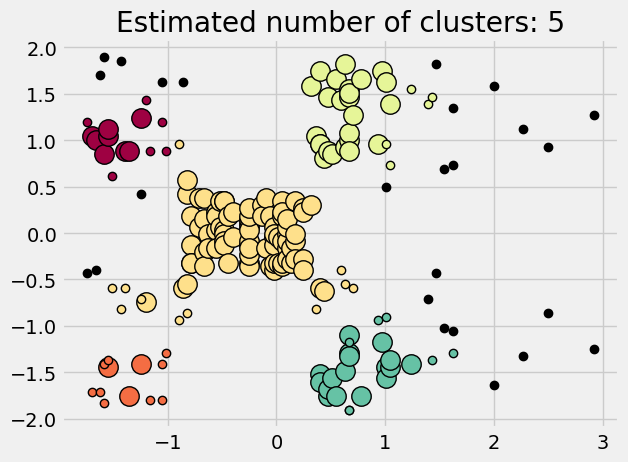

In [31]:
dbsc = DBSCAN(eps=0.4, min_samples=8).fit(x_std)
labels = dbsc.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)

unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbsc.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = x_std[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], "o", markerfacecolor=tuple(col), markeredgecolor="k", markersize=14)
    xy = x_std[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], "o", markerfacecolor=tuple(col), markeredgecolor="k", markersize=6)

plt.title(f"Estimated number of clusters: {n_clusters_}");

In [32]:
np.unique(dbsc.labels_)

array([-1,  0,  1,  2,  3,  4], dtype=int64)

### Evaluation 

In [33]:
sc_dbsc = silhouette_score(x_std, labels)
chc_dbsc = calinski_harabasz_score(x_std, labels) 
dbc_dbsc = davies_bouldin_score(x_std, labels)


pd.DataFrame(data={"silhoutte score" : [sc_dbsc], 
                   "calinski harabasz score ": [chc_dbsc], 
                   "davies bouldin score" : [dbc_dbsc]})

,silhoutte score,calinski harabasz score,davies bouldin score
0,0.414812,69.148532,1.65129


In [ ]:
!pip install tensorflow